Before starting to answer the questionnaire, I will do a small EDA to understand the data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
filename = 'data.csv'

In [3]:
! head -10 {filename}

symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,168.80,64.10,48.80,2548,dohc,four,130,mpfi,3.47,2.68,9.00,111,5000,21,27,16500
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.50,171.20,65.50,52.40,2823,ohcv,six,152,mpfi,2.68,3.47,9.00,154,5000,19,26,16500
2,164,audi,gas,std,four,sedan,fwd,front,99.80,176.60,66.20,54.30,2337,ohc,four,109,mpfi,3.19,3.40,10.00,102,5500,24,30,13950
2,164,audi,gas,std,four,sedan,4wd,front,99.40,176.60,66.40,54.30,2824,ohc,five,136,mpfi,3.19,3.40,8.00,115,5500,18,22,17450
2,?,audi,gas,std,two,sedan,fwd,front,99.80,177.30,66.30,53.10,2507,oh

Loading the CSV, From https://archive.ics.uci.edu/ml/datasets/automobile we find all the variable types, so we define. 

In [4]:
dtypes = {'symboling': int,'normalized-losses': np.float, 'make': str,
          'fuel-type': str, 'aspiration': str, 'num-of-doors': str,
          'body-style': str, 'drive-wheels': str, 'engine-location': str, 
          'wheel-base': np.float32, 'length': np.float32,'width': np.float32,
          'height': np.float32, 'curb-weight': np.float32, 'engine-type': str,
          'num-of-cylinders': str, 'engine-size': np.float32, 
          'fuel-system': str, 'bore': np.float32, 'stroke': np.float32,
          'compression-ratio': np.float32,  'horsepower': np.float32, 
          'peak-rpm': np.float32, 'city-mpg': np.float32,
          'highway-mpg': np.float32, 'price': np.float32,
         }

df = pd.read_csv(filename, na_values='?',dtype=dtypes)
df.shape

(205, 26)

Small data set, only 205 rows. Let's hope we have few null values

In [5]:
#check nan values
def check_nulls(df):
    nulls = df.isnull().sum(axis=0).reset_index()
    nulls.columns = ['column', 'missing']
    nulls = nulls[nulls['missing']>0]
    nulls = nulls.sort_values(by='missing', ascending=False)
    nulls['ratio'] = nulls.missing/df.shape[0]
    return nulls    

check_nulls(df)

,column,missing,ratio
1,normalized-losses,41,0.200000
18,bore,4,0.019512
19,stroke,4,0.019512
25,price,4,0.019512
5,num-of-doors,2,0.009756
21,horsepower,2,0.009756
22,peak-rpm,2,0.009756


It seems ok, but there are a lot of null values for `normalized-losses`

We noticed that the data is sorted by the `make` variable. So we will shuffle the dataframe to avoid any problem further. 

In [6]:
df =  df.sample(frac=1, random_state=42)
df.reset_index(drop=True, inplace=True)

Let's check some ditribution of the variables.

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


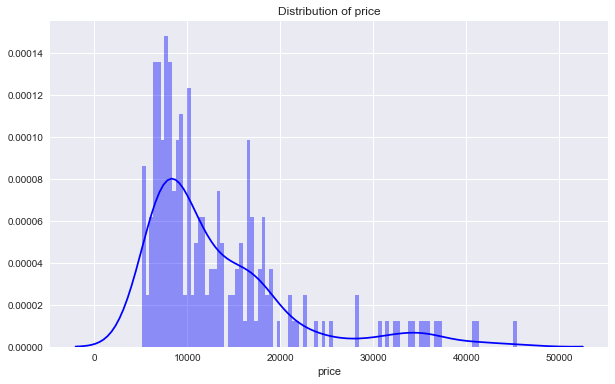

mean value = 13207.12890625


In [7]:
# Plot distribution of one feature
def plot_distribution(df,feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(df[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()   
    
plot_distribution(df, "price", "blue")
print('mean value = {}'.format(df.price.mean()))

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


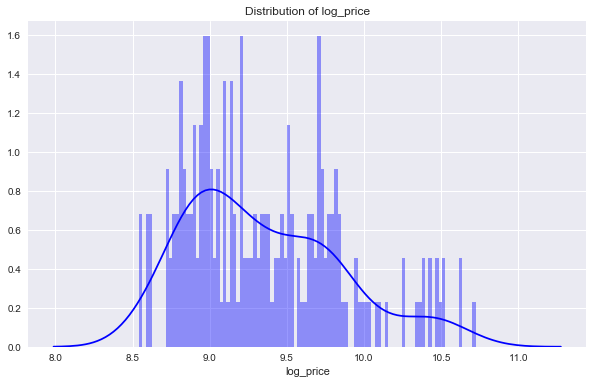

In [8]:
df['log_price'] = np.log1p(df.price)
plot_distribution(df, "log_price", "blue")  #checking if the log improves the distribution. 

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


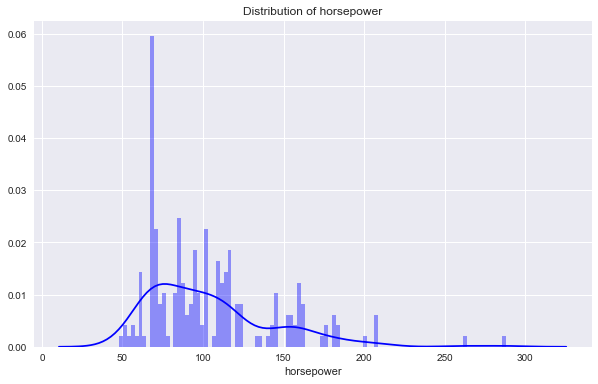

In [9]:
plot_distribution(df, "horsepower", "blue")

Let's check the correlation overall. 

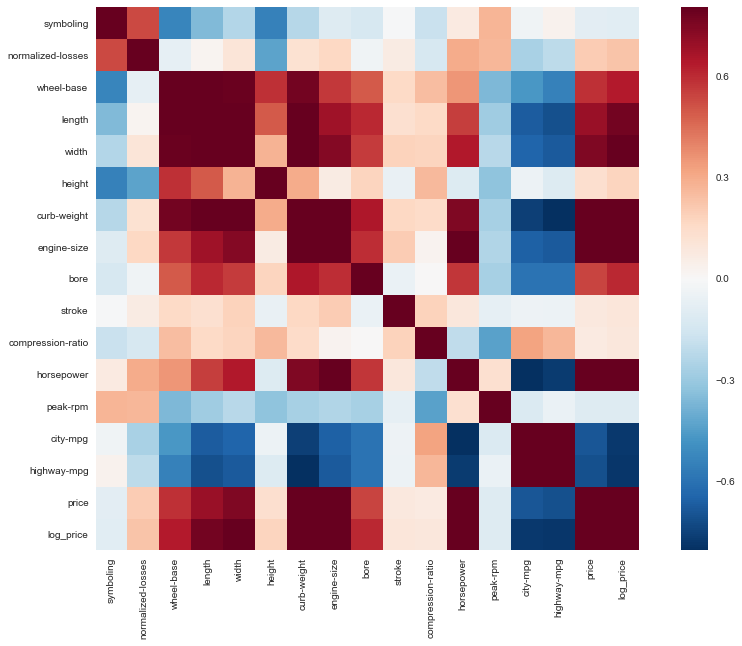

In [10]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=.8, square=True);

As expected `wheel-base`, `length`, `width` and `curb-weight` are very correlated. Also, price has a strong correlation with some variables:

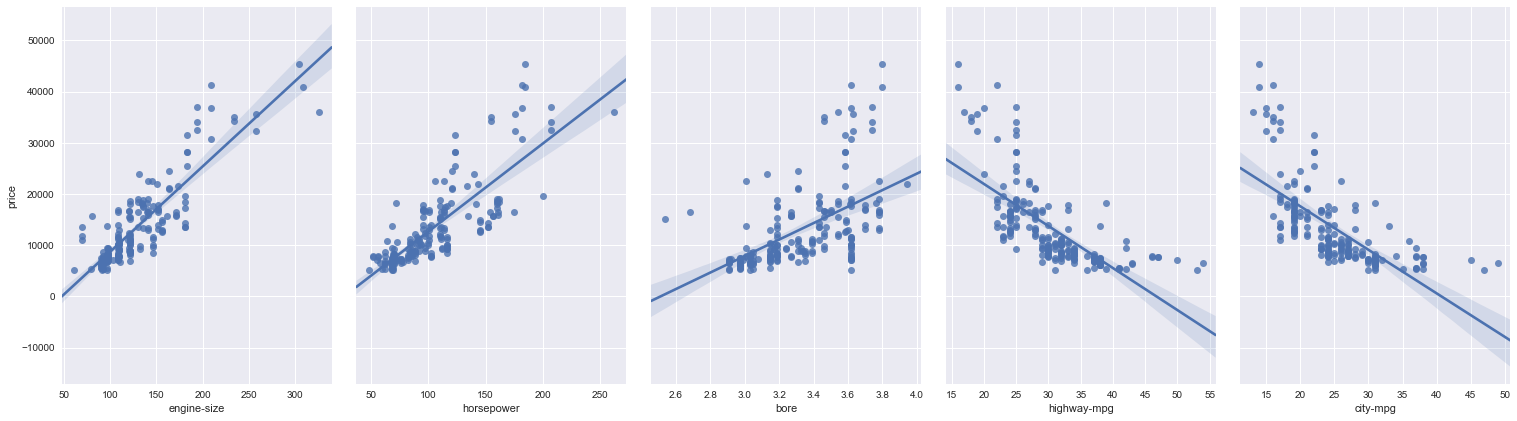

In [11]:
sns.pairplot(df, x_vars=['engine-size','horsepower','bore','highway-mpg','city-mpg'], y_vars='price',
             size=6, aspect=0.7, kind='reg')

Checking the categorical variables. 

/opt/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


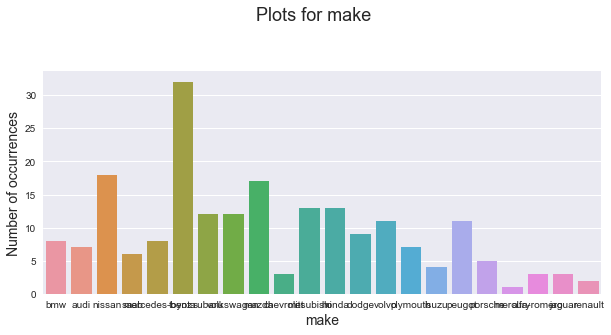

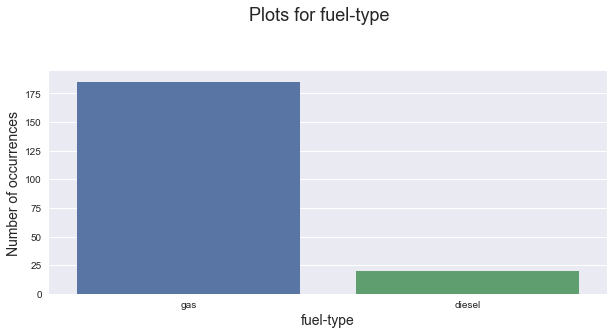

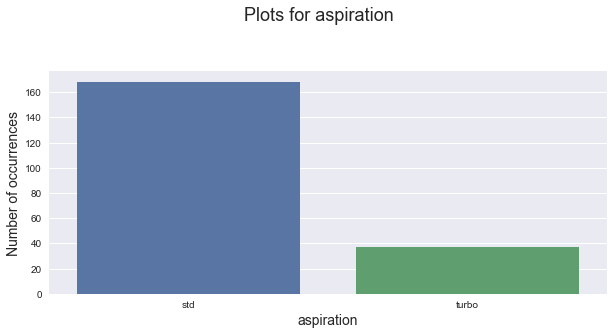

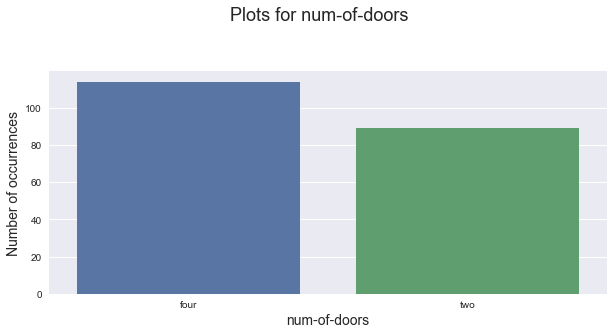

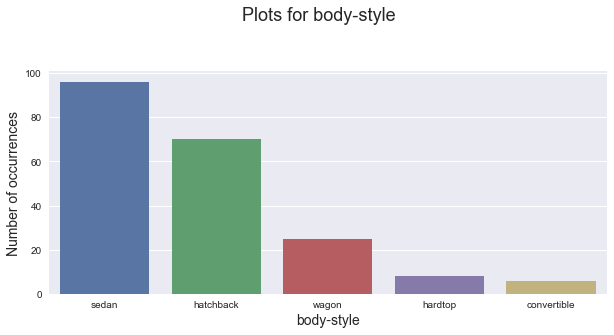

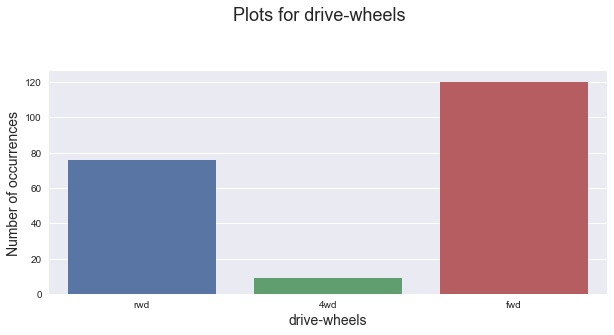

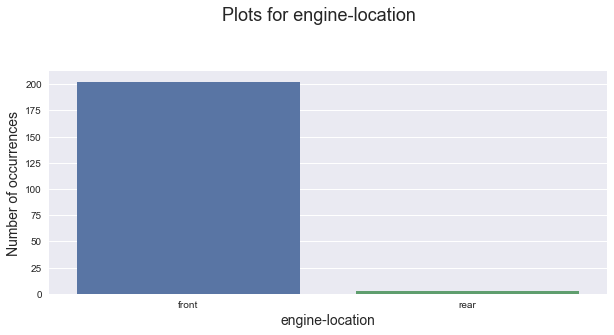

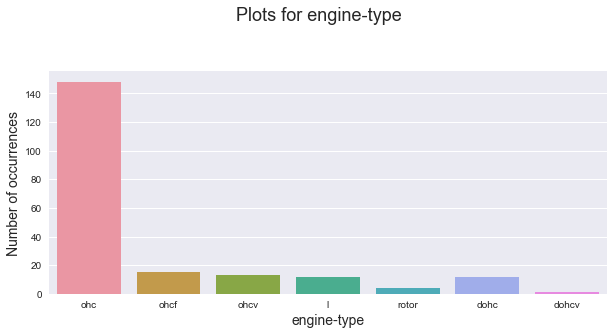

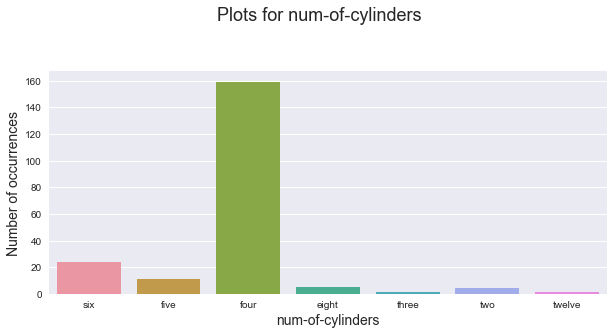

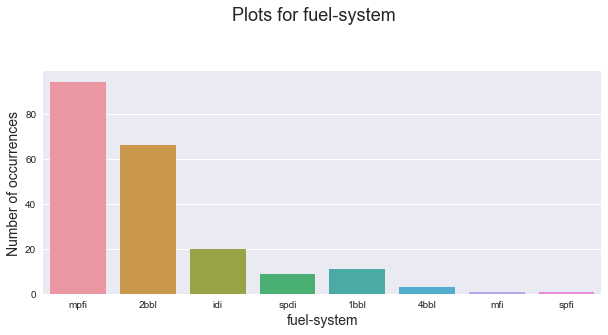

In [12]:
### Plotting Categorical Features
# Looping through and Plotting Categorical features
cols = [col for col in df.columns if df.dtypes[col] == object]
for column in cols:
    # Figure initiation
    fig = plt.figure(figsize=(10,9))
    
    ### Number of occurrences per categoty - target pair
    ax = sns.countplot(x=column, data=df, ax = plt.subplot(211));
    # X-axis Label
    plt.xlabel(column, fontsize=14);
    # Y-axis Label
    plt.ylabel('Number of occurrences', fontsize=14)
    # Adding Super Title (One for a whole figure)
    plt.suptitle('Plots for '+column, fontsize=18);
    
